In [1]:
from functools import partial
import os, argparse, torch, gc
import numpy as np
import torch.optim as optim
from torch.nn import MSELoss
from easydict import EasyDict as edict
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from leo_segmentation.data import Datagenerator, TrainingStats
from leo_segmentation.model import LEO, load_model, save_model
from leo_segmentation.utils import load_config, check_experiment, numpy_to_tensor,\
                get_named_dict, list_to_tensor, tensor_to_numpy, calc_iou_per_class
from run import train_model

c:\users\temil\onedrive\documents\codes_and_scripts\python_envs\pytorch-tf2-env\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\temil\onedrive\documents\codes_and_scripts\python_envs\pytorch-tf2-env\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\temil\onedrive\documents\codes_and_scripts\python_envs\pytorch-tf2-env\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


## Train

In [2]:
config = load_config()

In [3]:
leo, metadata, seg_weights = train_model(config)

num tasks: 7
tr_data shape: torch.Size([7, 2, 384, 512, 14]),tr_data_masks shape: torch.Size([7, 2, 384, 512]), val_data shape: torch.Size([7, 5, 384, 512, 14]),val_masks shape: torch.Size([7, 5, 384, 512])


C:\Users\temil\OneDrive\Documents\Study\UHildesheim\Project\Scripts\leo-srp-project\merge_to_dev\leo_segmentation\leo_segmentation\model.py:103: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output channels_last tensor even if some of the inputs are not in channels_last format. (Triggered internally at  ..\aten\src\ATen\native\TensorIterator.cpp:924.)
  channel_zero = inputs * predicted_weights[:, :14, :, :]
c:\users\temil\onedrive\documents\codes_and_scripts\python_envs\pytorch-tf2-env\lib\site-packages\torch\autograd\__init__.py:192: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  ..\aten\src\ATen\native\TensorIterator.cpp:918.)
  inputs, allow_unused)
585it [00:32, 18.10it/s]
202it [00:12, 16.34it/s]
87it [00:05, 15.57it/s]
115it [00:06, 18.19it/s]
102it [00:06, 15.71it/s]



mode:meta_val, episode:001, kl_loss:60423246385697377077952512.000000, total_meta_val_loss:0.733736 
val_mean_iou:{   'diningtable': 0.14977288151376272,
    'dog': 0.1682544352999362,
    'horse': 0.17117583509492945,
    'motorbike': 0.1533510656904263,
    'person': 0.13649845208511224}

Episode: 1, Episode Time: 3.088 minutes



585it [00:32, 18.16it/s]
202it [00:11, 18.21it/s]
87it [00:04, 17.90it/s]
115it [00:06, 18.35it/s]
102it [00:05, 18.31it/s]



mode:meta_val, episode:002, kl_loss:9307844929165457358848.000000, total_meta_val_loss:0.710322 
val_mean_iou:{   'diningtable': 0.15639082729607998,
    'dog': 0.17359663418364288,
    'horse': 0.16961225931113325,
    'motorbike': 0.15144211405245478,
    'person': 0.1295052986877967}

Episode: 2, Episode Time: 2.953 minutes



585it [00:32, 18.00it/s]
87it [00:04, 18.10it/s]
115it [00:06, 18.21it/s]
202it [00:11, 18.28it/s]
102it [00:05, 18.11it/s]



mode:meta_val, episode:003, kl_loss:2535291682453025602928640.000000, total_meta_val_loss:0.693010 
val_mean_iou:{   'diningtable': 0.1394835179082187,
    'dog': 0.17732670894866048,
    'horse': 0.17415441632189863,
    'motorbike': 0.14736309467072553,
    'person': 0.1243399434360829}

Episode: 3, Episode Time: 2.956 minutes



102it [00:05, 17.99it/s]
115it [00:06, 18.23it/s]
202it [00:11, 18.20it/s]
585it [00:32, 18.13it/s]
87it [00:04, 18.17it/s]



mode:meta_val, episode:004, kl_loss:99702246796199110639616.000000, total_meta_val_loss:0.683811 
val_mean_iou:{   'diningtable': 0.14040602875973712,
    'dog': 0.17913017118628566,
    'horse': 0.17690563386065156,
    'motorbike': 0.1442078136595707,
    'person': 0.11972185122218018}

Episode: 4, Episode Time: 2.956 minutes



115it [00:06, 18.42it/s]
102it [00:05, 18.12it/s]
87it [00:04, 18.31it/s]
585it [00:31, 18.39it/s]
202it [00:10, 18.38it/s]



mode:meta_val, episode:005, kl_loss:2081171322113512695660544.000000, total_meta_val_loss:0.665860 
val_mean_iou:{   'diningtable': 0.12931712874902396,
    'dog': 0.18455155739726906,
    'horse': 0.17737829277655542,
    'motorbike': 0.14235735367274477,
    'person': 0.11460811405125831}

Episode: 5, Episode Time: 2.928 minutes



202it [00:10, 18.44it/s]
115it [00:06, 18.25it/s]
87it [00:04, 18.25it/s]
102it [00:05, 18.19it/s]
585it [00:31, 18.44it/s]



mode:meta_val, episode:006, kl_loss:3090902896432547627008.000000, total_meta_val_loss:0.654604 
val_mean_iou:{   'diningtable': 0.12331393529042015,
    'dog': 0.19044305295662586,
    'horse': 0.18510490208622626,
    'motorbike': 0.13981250354994926,
    'person': 0.10913289086697384}

Episode: 6, Episode Time: 2.931 minutes



87it [00:04, 18.24it/s]
115it [00:06, 18.29it/s]
102it [00:05, 18.18it/s]
202it [00:11, 18.32it/s]
585it [00:31, 18.46it/s]



mode:meta_val, episode:007, kl_loss:1137721081808285597696.000000, total_meta_val_loss:0.641122 
val_mean_iou:{   'diningtable': 0.11718889450351044,
    'dog': 0.19688273194982994,
    'horse': 0.195004327157408,
    'motorbike': 0.13863624253508752,
    'person': 0.10287525791320154}

Episode: 7, Episode Time: 2.934 minutes



87it [00:04, 18.51it/s]
115it [00:06, 17.59it/s]
202it [00:11, 17.11it/s]
102it [00:05, 18.06it/s]
585it [00:33, 17.67it/s]



mode:meta_val, episode:008, kl_loss:1932293004647727104.000000, total_meta_val_loss:0.627656 
val_mean_iou:{   'diningtable': 0.11053273142291872,
    'dog': 0.20009554232903592,
    'horse': 0.1911274567830867,
    'motorbike': 0.13843129120367523,
    'person': 0.09972837694214245}

Episode: 8, Episode Time: 3.003 minutes



585it [00:34, 16.74it/s]
87it [00:05, 15.16it/s]
202it [00:12, 16.60it/s]
102it [00:06, 16.01it/s]
115it [00:07, 16.36it/s]



mode:meta_val, episode:009, kl_loss:178742908213870460928.000000, total_meta_val_loss:0.622598 
val_mean_iou:{   'diningtable': 0.10584398707646202,
    'dog': 0.20953815997429845,
    'horse': 0.199889890508308,
    'motorbike': 0.13307026821530502,
    'person': 0.09356764190442707}

Episode: 9, Episode Time: 3.256 minutes



585it [00:36, 16.16it/s]
87it [00:05, 16.50it/s]
202it [00:12, 16.58it/s]
102it [00:06, 16.50it/s]
115it [00:07, 16.41it/s]



mode:meta_val, episode:010, kl_loss:3415012043440636559360.000000, total_meta_val_loss:0.614620 
val_mean_iou:{   'diningtable': 0.10052900043797418,
    'dog': 0.212620540939777,
    'horse': 0.20292753752472856,
    'motorbike': 0.12928653398623804,
    'person': 0.08940134830920883}

Episode: 10, Episode Time: 3.268 minutes



202it [00:11, 17.91it/s]
102it [00:05, 17.58it/s]
585it [00:34, 17.04it/s]
87it [00:05, 15.80it/s]
115it [00:06, 17.36it/s]



mode:meta_val, episode:011, kl_loss:301331401510928045309952.000000, total_meta_val_loss:0.604840 
val_mean_iou:{   'diningtable': 0.10233465201858848,
    'dog': 0.23408890620885625,
    'horse': 0.20420622121839435,
    'motorbike': 0.12747566499284652,
    'person': 0.08456807869786605}

Episode: 11, Episode Time: 3.207 minutes



585it [00:33, 17.64it/s]
115it [00:06, 17.80it/s]
87it [00:04, 17.73it/s]
102it [00:05, 17.92it/s]
202it [00:12, 15.95it/s]



mode:meta_val, episode:012, kl_loss:276532874253942390784.000000, total_meta_val_loss:0.598328 
val_mean_iou:{   'diningtable': 0.08822766830841237,
    'dog': 0.22497379827758343,
    'horse': 0.20653491852050027,
    'motorbike': 0.12471950334227101,
    'person': 0.08893405968829435}

Episode: 12, Episode Time: 3.069 minutes



202it [00:11, 17.61it/s]
102it [00:05, 17.66it/s]
87it [00:04, 17.88it/s]
585it [00:34, 16.90it/s]
115it [00:06, 18.05it/s]



mode:meta_val, episode:013, kl_loss:16200095472000434176.000000, total_meta_val_loss:0.586689 
val_mean_iou:{   'diningtable': 0.08353020538918819,
    'dog': 0.23183622514035176,
    'horse': 0.2131627015536236,
    'motorbike': 0.12198315906904875,
    'person': 0.06632873530843068}

Episode: 13, Episode Time: 3.076 minutes



87it [00:04, 17.95it/s]
202it [00:12, 15.80it/s]
102it [00:05, 18.01it/s]
115it [00:06, 17.83it/s]
585it [00:32, 17.93it/s]



mode:meta_val, episode:014, kl_loss:820105210669190610944.000000, total_meta_val_loss:0.585697 
val_mean_iou:{   'diningtable': 0.08000564988769238,
    'dog': 0.2367732375618634,
    'horse': 0.2210908021856314,
    'motorbike': 0.11946560265040793,
    'person': 0.07027820868457374}

Episode: 14, Episode Time: 3.057 minutes



585it [00:32, 17.82it/s]
102it [00:05, 17.74it/s]
115it [00:06, 17.74it/s]
87it [00:05, 15.58it/s]
202it [00:12, 16.28it/s]



mode:meta_val, episode:015, kl_loss:1172703475898079332270080.000000, total_meta_val_loss:0.579945 
val_mean_iou:{   'diningtable': 0.07136837780681518,
    'dog': 0.2442047955736232,
    'horse': 0.2287832239539137,
    'motorbike': 0.11818122489547427,
    'person': 0.0646719659471847}

Episode: 15, Episode Time: 3.061 minutes



585it [00:34, 16.79it/s]
115it [00:06, 17.89it/s]
87it [00:04, 17.48it/s]
202it [00:11, 17.79it/s]
102it [00:05, 17.87it/s]



mode:meta_val, episode:016, kl_loss:179952159898191527936.000000, total_meta_val_loss:0.574663 
val_mean_iou:{   'diningtable': 0.06719982133186533,
    'dog': 0.24825981740945743,
    'horse': 0.2242974486902644,
    'motorbike': 0.11340471442096678,
    'person': 0.060085158228709225}

Episode: 16, Episode Time: 3.060 minutes



87it [00:04, 17.52it/s]
102it [00:05, 17.62it/s]
115it [00:06, 17.53it/s]
202it [00:11, 17.78it/s]
585it [00:34, 16.72it/s]



mode:meta_val, episode:017, kl_loss:18354897662908957720576.000000, total_meta_val_loss:0.568468 
val_mean_iou:{   'diningtable': 0.06251471500940294,
    'dog': 0.25380520175453974,
    'horse': 0.22947894670100846,
    'motorbike': 0.11449462982635601,
    'person': 0.055558633185962256}

Episode: 17, Episode Time: 3.064 minutes



102it [00:06, 15.48it/s]
87it [00:05, 15.58it/s]
115it [00:07, 15.41it/s]
585it [00:32, 18.12it/s]
202it [00:12, 16.02it/s]



mode:meta_val, episode:018, kl_loss:7215642913814872064.000000, total_meta_val_loss:0.560383 
val_mean_iou:{   'diningtable': 0.054628256377324276,
    'dog': 0.2631464356562736,
    'horse': 0.2344174486624397,
    'motorbike': 0.12119685895307693,
    'person': 0.05193770419307567}

Episode: 18, Episode Time: 3.081 minutes



102it [00:06, 15.59it/s]
585it [00:32, 18.11it/s]
115it [00:07, 15.56it/s]
87it [00:05, 15.05it/s]
202it [00:12, 15.57it/s]



mode:meta_val, episode:019, kl_loss:13991580742451200.000000, total_meta_val_loss:0.552228 
val_mean_iou:{   'diningtable': 0.051403468036956265,
    'dog': 0.2676593507127445,
    'horse': 0.24054210269990967,
    'motorbike': 0.11418083223336858,
    'person': 0.048343905368603494}

Episode: 19, Episode Time: 3.092 minutes



585it [00:35, 16.69it/s]
102it [00:06, 15.20it/s]
87it [00:04, 17.45it/s]
202it [00:11, 17.98it/s]
115it [00:07, 15.45it/s]



mode:meta_val, episode:020, kl_loss:51643392653569032192.000000, total_meta_val_loss:0.550458 
val_mean_iou:{   'diningtable': 0.02722844697399646,
    'dog': 0.2739674874677913,
    'horse': 0.24105947220001864,
    'motorbike': 0.10716380488686839,
    'person': 0.044582052672591056}

Episode: 20, Episode Time: 3.098 minutes



585it [00:36, 15.96it/s]
102it [00:06, 15.40it/s]
202it [00:12, 16.11it/s]
87it [00:05, 15.30it/s]
115it [00:07, 15.27it/s]



mode:meta_val, episode:021, kl_loss:345815751468253184.000000, total_meta_val_loss:0.546948 
val_mean_iou:{   'diningtable': 0.04142328885768584,
    'dog': 0.27747190774115976,
    'horse': 0.27982170562231046,
    'motorbike': 0.10626974180589616,
    'person': 0.040950006840579506}

Episode: 21, Episode Time: 3.163 minutes



585it [00:36, 15.83it/s]
87it [00:04, 17.51it/s]
115it [00:06, 18.24it/s]
202it [00:12, 15.56it/s]
102it [00:06, 15.05it/s]



mode:meta_val, episode:022, kl_loss:242121291713669496832.000000, total_meta_val_loss:0.547463 
val_mean_iou:{   'diningtable': 0.03678446682968276,
    'dog': 0.28352737318784244,
    'horse': 0.24960973081913784,
    'motorbike': 0.10362718121404015,
    'person': 0.036838335860791924}

Episode: 22, Episode Time: 3.143 minutes



585it [00:37, 15.67it/s]
202it [00:11, 16.91it/s]
115it [00:07, 15.17it/s]
87it [00:05, 15.36it/s]
102it [00:06, 15.31it/s]



mode:meta_val, episode:023, kl_loss:94391530058009783828480.000000, total_meta_val_loss:0.542333 
val_mean_iou:{   'diningtable': 0.03458771842364579,
    'dog': 0.28917009145121003,
    'horse': 0.2536268584620388,
    'motorbike': 0.09990431145003324,
    'person': 0.03430902192554484}

Episode: 23, Episode Time: 3.161 minutes



202it [00:11, 17.79it/s]
102it [00:05, 17.96it/s]
115it [00:06, 18.13it/s]
87it [00:04, 18.06it/s]
585it [00:37, 15.62it/s]



mode:meta_val, episode:024, kl_loss:224105689788710912.000000, total_meta_val_loss:0.538717 
val_mean_iou:{   'diningtable': 0.029193754246267023,
    'dog': 0.29317719565516426,
    'horse': 0.2582858339473453,
    'motorbike': 0.10074941355001876,
    'person': 0.031135177581581318}

Episode: 24, Episode Time: 3.106 minutes



87it [00:05, 15.83it/s]
202it [00:13, 15.49it/s]
102it [00:06, 15.47it/s]
115it [00:07, 15.28it/s]
585it [00:37, 15.48it/s]



mode:meta_val, episode:025, kl_loss:16858252137270870016.000000, total_meta_val_loss:0.520204 
val_mean_iou:{   'diningtable': 0.025226878433413532,
    'dog': 0.30586456653632543,
    'horse': 0.30591748236337524,
    'motorbike': 0.0984649245037478,
    'person': 0.028847270031046666}

Episode: 25, Episode Time: 3.190 minutes



202it [00:12, 15.63it/s]
585it [00:33, 17.37it/s]
115it [00:07, 14.69it/s]
87it [00:05, 15.42it/s]
102it [00:06, 15.25it/s]



mode:meta_val, episode:026, kl_loss:5638604590002733056.000000, total_meta_val_loss:0.520543 
val_mean_iou:{   'diningtable': 0.022343503722491647,
    'dog': 0.3506531512346703,
    'horse': 0.26604057992485625,
    'motorbike': 0.10112383109641773,
    'person': 0.0265772836727514}

Episode: 26, Episode Time: 3.122 minutes



202it [00:13, 15.53it/s]
585it [00:37, 15.55it/s]
87it [00:05, 15.50it/s]
115it [00:07, 15.40it/s]
102it [00:06, 15.31it/s]



mode:meta_val, episode:027, kl_loss:291249499269908377108480.000000, total_meta_val_loss:0.527313 
val_mean_iou:{   'diningtable': 0.019349595052925543,
    'dog': 0.30580473433663735,
    'horse': 0.2695308086344525,
    'motorbike': 0.09276657295269466,
    'person': 0.0245680448400847}

Episode: 27, Episode Time: 3.175 minutes



115it [00:06, 18.10it/s]
102it [00:05, 17.95it/s]
87it [00:04, 17.92it/s]
202it [00:12, 15.65it/s]
585it [00:37, 15.47it/s]



mode:meta_val, episode:028, kl_loss:25723234761450012540928.000000, total_meta_val_loss:0.525413 
val_mean_iou:{   'diningtable': 0.01793887503671175,
    'dog': 0.307186460669033,
    'horse': 0.2683683943540648,
    'motorbike': 0.09159011454186727,
    'person': 0.022890618768449004}

Episode: 28, Episode Time: 3.131 minutes



585it [00:35, 16.32it/s]
115it [00:07, 15.08it/s]
202it [00:13, 14.83it/s]
102it [00:06, 15.14it/s]
87it [00:05, 15.08it/s]



mode:meta_val, episode:029, kl_loss:5503953448262959104.000000, total_meta_val_loss:0.520382 
val_mean_iou:{   'diningtable': 0.01618149901134732,
    'dog': 0.3085360638461097,
    'horse': 0.27249247889161915,
    'motorbike': 0.09761513060383704,
    'person': 0.023268345548309314}

Episode: 29, Episode Time: 3.300 minutes



115it [00:07, 15.78it/s]
202it [00:11, 17.80it/s]
87it [00:04, 17.61it/s]
102it [00:05, 17.72it/s]
585it [00:38, 15.29it/s]



mode:meta_val, episode:030, kl_loss:554144114328035393536.000000, total_meta_val_loss:0.509764 
val_mean_iou:{   'diningtable': 0.014723561588357895,
    'dog': 0.321298611478812,
    'horse': 0.3073190439896708,
    'motorbike': 0.090827379075229,
    'person': 0.02038055621402746}

Episode: 30, Episode Time: 3.186 minutes



124it [00:08, 15.22it/s]
87it [00:05, 14.94it/s]
114it [00:07, 14.93it/s]
104it [00:06, 15.16it/s]
107it [00:07, 15.01it/s]



mode:meta_test, episode:030, kl_loss:4914307647188362067968.000000, total_meta_test_loss:0.522660 
val_mean_iou:{   'pottedplant': 0.02273585486039972,
    'sheep': 0.31753462747670697,
    'sofa': 0.038147555332238174,
    'train': 0.020921020602672456,
    'tvmonitor': 0.020217056956145712}

Total Model Training Time 92.817 minutes



## Predictions on Meta Val / Test

In [4]:
leo

LEO(
  (encoder): Sequential(
    (0): Conv2d(14, 28, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Flatten()
    (5): Linear(in_features=1376256, out_features=100, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=1376256, bias=True)
    (1): ReLU(inplace=True)
    (2): Reshape()
    (3): ConvTranspose2d(28, 28, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
  )
)

## Evaluation

In [106]:
mode = "meta_val"
dataloader = Datagenerator(config, dataset="pascal_voc", data_type=mode)
val_meta_data = dataloader.get_batch_data()
print(f"classes in mode {mode}: {val_meta_data[-1]}")

classes in mode meta_val: ['diningtable', 'motorbike', 'horse', 'dog', 'person']


In [108]:
select_class = 3
channels_to_view = 6,9
pred_data_index = list(range(5))
print("class", class_in_metadata[select_class], "is selected")
batch_data = get_named_dict(val_meta_data, select_class)

class horse is selected


In [109]:
#generate latents on training data
latents, kl_loss = leo.forward_encoder(batch_data.tr_data)
#perform innerloop updates to generate weights
tr_loss, adapted_seg_weights = leo.leo_inner_loop(batch_data.tr_data, latents, batch_data.tr_data_masks)
#fine tune the weights
_, _, seg_weights = leo.finetuning_inner_loop(batch_data, tr_loss,adapted_seg_weights, mode, inference=True)

#prepare validation set
if type(pred_data_index) == list:
    input_embedding = torch.cat([list_to_tensor(batch_data.val_data[i]) for i in pred_data_index])
    input_mask = torch.cat([list_to_tensor(batch_data.val_data_masks[i]) for i in pred_data_index])
else:
    input_embedding = list_to_tensor(batch_data.val_data[pred_data_index])
    input_mask = list_to_tensor(batch_data.val_data_masks[pred_data_index])

#predict on training data
val_loss, predictions = leo.calculate_inner_loss(input_embedding, input_mask, seg_weights)
predictions = np.argmax(tensor_to_numpy(predictions), 1) 
embeddings = tensor_to_numpy(input_embedding.permute(0, 2, 3, 1))

In [112]:
def plot_batch_mask(embeds, preds, masks, emb_channels):
    fig = plt.figure(figsize=(20,16))
    for i in range(0, len(preds)):
        embed = np.squeeze(embeds) if len(embeds) == 1 else embeds[i]
        pred = np.squeeze(preds) if len(preds) == 1 else preds[i]
        mask = np.squeeze(masks) if len(masks) == 1 else masks[i]
        
        fig.add_subplot(len(preds), 3, i*3+1)
        plt.imshow(embed[:, :, emb_channels[0]:emb_channels[1]])
        plt.title("3 embeddings_channels")
        
        fig.add_subplot(len(preds), 3, i*3+2)
        plt.imshow(mask, cmap="gray")
        plt.title("ground_truth")
        
        fig.add_subplot(len(preds), 3, i*3+3)
        plt.imshow(pred, cmap="gray")
        plt.title("prediction")
        
    plt.subplots_adjust(hspace=0.5)
    plt.show()
    return

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


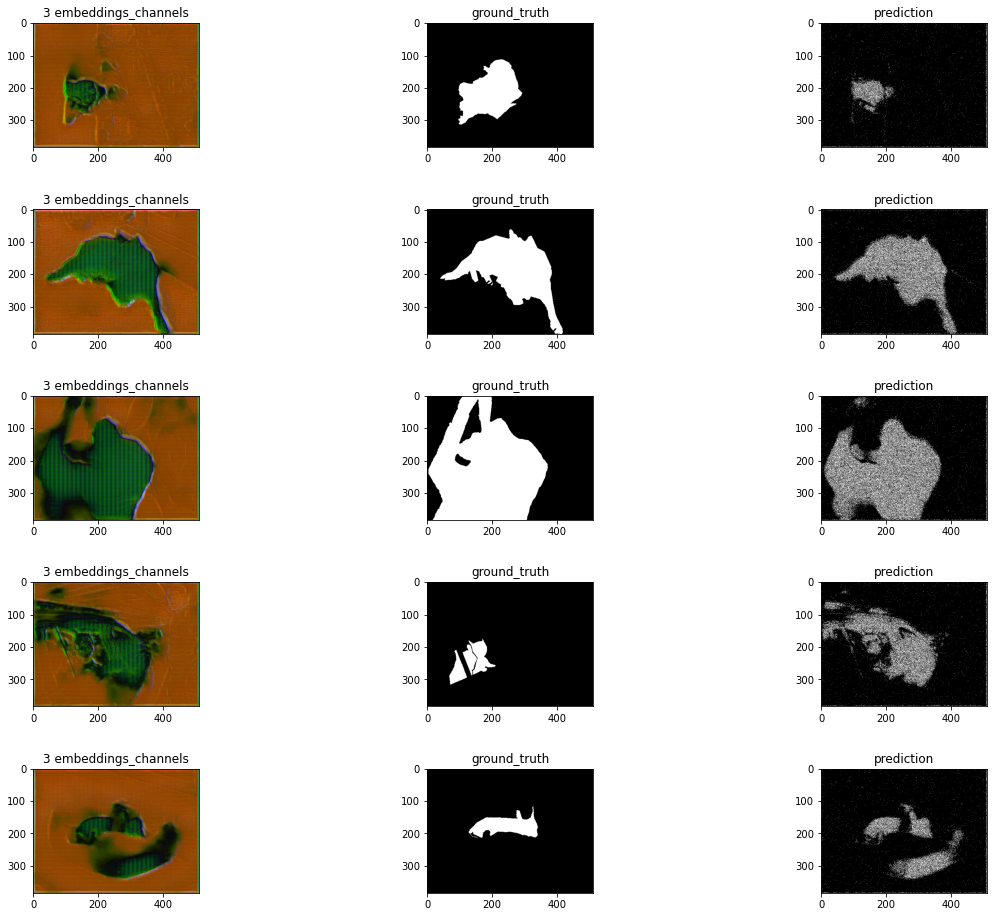

In [113]:
plot_batch_mask(embeddings, predictions, input_mask, channels_to_view)